In [1]:
import Pkg: activate, build
activate("../GSHEIntegrator/.")
import GSHEIntegrator;


import Plots
using LaTeXStrings
using Measures
using NPZ
using EllipsisNotation

  Activating project at `~/Projects/birefringence/GSHEIntegrator`
┌ Info: Precompiling GSHEIntegrator [95376d2f-314f-47c4-97a6-da6eee6a3a26]
└ @ Base loading.jl:1423


In [28]:
log10(0.5)

-0.3010299956639812

In [23]:
ϵs = (10).^(LinRange(-3, log10(0.6), 50))
rsource = 10.
θsource = 0.5π
ϕsource = 0.0

robs = 100.0
θobs = 0.4π
ϕobs = 1π

as = 0.99

postproc_options = GSHEIntegrator.PostprocOptions(check_sols=true)
ode_options = GSHEIntegrator.ODESolverOptions(Δθ=0.0, horizon_tol=1.0001, no_loops=true, maxiters=100000)
opt_options = GSHEIntegrator.OptimiserOptions(Nconsec=20)


geometry = GSHEIntegrator.setup_geometry(Float64;
   rsource=rsource, θsource=θsource, ϕsource=ϕsource,
   robs=robs, θobs=θobs, ϕobs=ϕobs, a=as, s=2, postproc_options=postproc_options, ode_options=ode_options);

In [24]:
Xgeo, Xgshe = GSHEIntegrator.solve_full(geometry, ϵs, true, 2, perturbation_verbose=false);

In [25]:
αs, βs = GSHEIntegrator.fit_Δts(ϵs, Xgshe, Xgeo, geometry)

2-element Vector{Any}:
 [Dict("alpha" => [1.9967632375955675, 0.0003607239839115338], "beta" => [0.05700290059231827, 9.33531013990724e-5]), Dict("alpha" => [2.006030195168271, 0.0010538435562418879], "beta" => [0.05984477409700591, 0.0002940370009789162])]
 [Dict("alpha" => [2.0007627227864355, 9.212507741936187e-5], "beta" => [0.05513247523784476, 2.3334813894094197e-5]), Dict("alpha" => [1.9988899003335008, 0.0001713405672549029], "beta" => [0.0545918761304944, 4.2950554309957364e-5])]

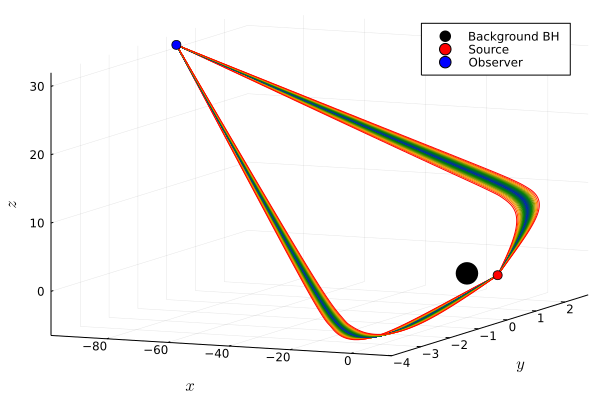

In [5]:
cols = [Plots.cgrad(:rainbow, [minimum(ϵs), maximum(ϵs)], scale=:log)[1000^z] for z in range(-1, 0, length = length(ϵs))]
transform(x::Vector{<:Real}) = GSHEIntegrator.spherical_to_cartesian(x, geometry.a)

fig = Plots.plot(dpi=450, figsize=(3.45*1, 3.45*0.75), xlabel=L"x", ylabel=L"y", zlabel=L"z")

for i in 1:2, s in 1:2, j in 1:size(Xgshe, 3)
    sol = GSHEIntegrator.solve_problem(
        Xgshe[i, s, j, 1:2], geometry, ϵs[j], s == 1 ? 2 : -2; save_everystep=true)
    tr = mapslices(transform, sol[2:4, :], dims=1)
    Plots.plot!(fig, [tr[i, :] for i in 1:3]..., label=nothing, c=cols[j])

end

GSHEIntegrator.plotbh!(fig)
GSHEIntegrator.plot_start_end!(fig, geometry)

Plots.savefig(fig, "~/Downloads/trajectory.pdf")
display(fig)

In [14]:
geometry.ode_options.no_loops = false

N = 500
k2s = LinRange(-1, 1, N)
k3s = LinRange(-1, 1, N)

dirs = GSHEIntegrator.make_2dmesh(k2s, k3s)

mask = reshape(mapslices(x->sum(x) ≤ 1 , dirs.^2, dims=2), N^2)
iters = [i for i in 1:N^2 if mask[i]]
GSHEIntegrator.shuffle!(iters)
Z = fill(NaN, N^2)
loss = GSHEIntegrator.setup_initial_loss(geometry, 0, 2);

Threads.@threads for i in iters
    k2, k3 = dirs[i, :]
    ψ = acos(k3)
    ρ = π + asin(k2 / sqrt(1 - k3^2))
    Z[i] = loss([ψ, ρ])
end

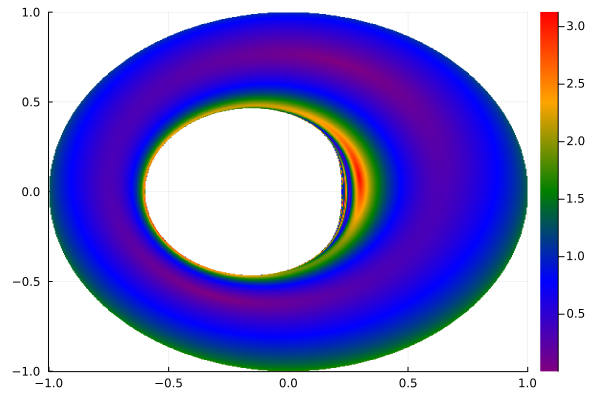

In [15]:
fig = Plots.heatmap(k2s, k3s, transpose(reshape(Z, N, N)), c=:rainbow, dpi=300)


Plots.savefig("~/Downloads/loss.png")

display(fig)


In [26]:
npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss_Xgeo.npy", Xgeo)
npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss_Xgshe.npy", Xgshe)
npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss_eps.npy", ϵs)

npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss_k2.npy", k2s)
npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss_k3.npy", k3s)
npzwrite("/Users/richard/Projects/birefringence/data/shadow/loss.npy", Z)